# Experementing with generating weather data
To generate realistic weather data, we need to consider the following factors:
1. The weather changes over the course of a day. 
2. The weather changes over the course of a year, that is we have seasons.
3. We will need to consider the last generated weather data to generate the next data point, so the fluctuations in the weather are not too large.

We will create a function that generates hourly weather data beteen two dates. The function will take the following parameters:
1. start_date: The start date of the weather data
2. end_date: The end date of the weather data

The function will return a dataframe with the following columns:
1. Temperature: The temperature in degrees celsius
2. Humidity: The humidity in percentage
3. Precipitation: The precipitation in mm/hour

The index of the dataframe will be the date and time of the weather data.

We will do it using the following steps:

1. Create the index of the dataframe, that will be the date and time of the weather data. We will use the pandas date_range function to create the index.

2. Create the temperature data. We will first create something we call temp_seasonal. This can be considered a base value for the temperature for each day.
    - We will create this using the following formula: temp_seasonal = sin((month - 1) / 12 * 2 * pi) * 15 + 15. This will give us a value between 0 and 30, with 15 being the average temperature. 
    - We then clip the values to be between -20 and 25. This will give us a value between -20 and 25, with 15 being the average temperature.
    - Now we will create a diurnal temperature variation. We will do this by creating a temp_diurnal variable. This value is used to get the diurnal temperature variation for the day. We will use the following formula: temp_diurnal = cos((hour - 12) / 24 * 2 * pi) * 5. This will give us a value between -5 and 5, with 0 being the average temperature.
    - We will then calculate a random noise value for the temperature. This is because we want to have some random fluctuations in the temperature. We will use the following formula: temp_noise = np.random.normal(0, 2, len(index)). This will give us a value between -2 and 2, with 0 being the average temperature.
    - We will then add the temp_seasonal, temp_diurnal and temp_noise to get the temperature for each hour.

In [1]:
import numpy as np
import pandas as pd

In [11]:
def generate_weather(start_date, end_date):
    # Create a time index with hourly frequency
    idx = pd.date_range(start_date, end_date, freq='H')

    # Extract months and hours for our calculations
    month = idx.month
    hour = idx.hour

    # Generate temperature data with seasonal variation and diurnal cycle
    temp_seasonal = pd.Series((np.sin((month - 1) / 12 * 2 *np.pi) * 15 + 15), index=idx)
    temp_seasonal = temp_seasonal.clip(lower=-20, upper=25)
    temp_diurnal = np.cos((hour - 12) / 24 * 2 * np.pi) * 5
    temp_noise = np.random.normal(0, 2, len(idx))
    temp = temp_seasonal + temp_diurnal + temp_noise

    # Generate humidity data with diurnal cycle and random noice
    hum_diurnal = np.sin((hour - 6) / 24 * 2 * np.pi) * 20
    hum_noise = np.random.normal(0, 5, len(idx))
    hum = 50 + hum_diurnal + hum_noise

    # Generate precipitation data with random noce and higher probability during summer
    p_seasonal = np.sin((month - 1) / 12 * 2 * np.pi) * 0.1 + 0.2
    p_summer = (temp > 20) & (np.random.rand(len(idx)) < p_seasonal)
    p_noise = np.random.normal(0, 0.05, len(idx))
    p = p_summer.astype(float) * (0.1 + p_noise)
    
    # Create a pandas dataframe with the generated values
    data = {'Temperature': temp, 'Humidity': hum, 'Precipitation': p}
    df = pd.DataFrame(data, index=idx)
    return df

In [15]:
weather_df = generate_weather('2018-01-01', '2018-12-31')

In [13]:
weather_df.head()

,Temperature,Humidity,Precipitation
2018-06-01 00:00:00,18.448580,34.657600,0.0
2018-06-01 01:00:00,16.876978,30.002581,0.0
2018-06-01 02:00:00,15.790574,31.996498,0.0
2018-06-01 03:00:00,19.209383,38.504784,0.0
2018-06-01 04:00:00,18.062748,43.528810,0.0


In [20]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

def plot(weather_data, title):
    # Create the subplots
    fig, ax1  = plt.subplots(figsize=(12, 8))

    # Define the custom date format
    date_fmt = mdates.DateFormatter("%Y-%m-%d")

    plt.title(title)

    # Plot temperature
    ax1.plot(weather_data.index, weather_data['Temperature'], label='Temperature', color='r')
    ax1.set_ylabel('Temperature (°C)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='upper left')
    ax1.xaxis.set_major_formatter(date_fmt)

    # Add a second y-axis for Humidity
    ax2 = ax1.twinx()
    ax2.plot(weather_data.index, weather_data['Humidity'], label='Humidity', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='upper center')

    # Add a third y-axis for Precipitation
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.1))
    ax3.plot(weather_data.index, weather_data['Precipitation'], label='Precipitation', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend(loc='upper right')

    ax1.set_xlabel('Date')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


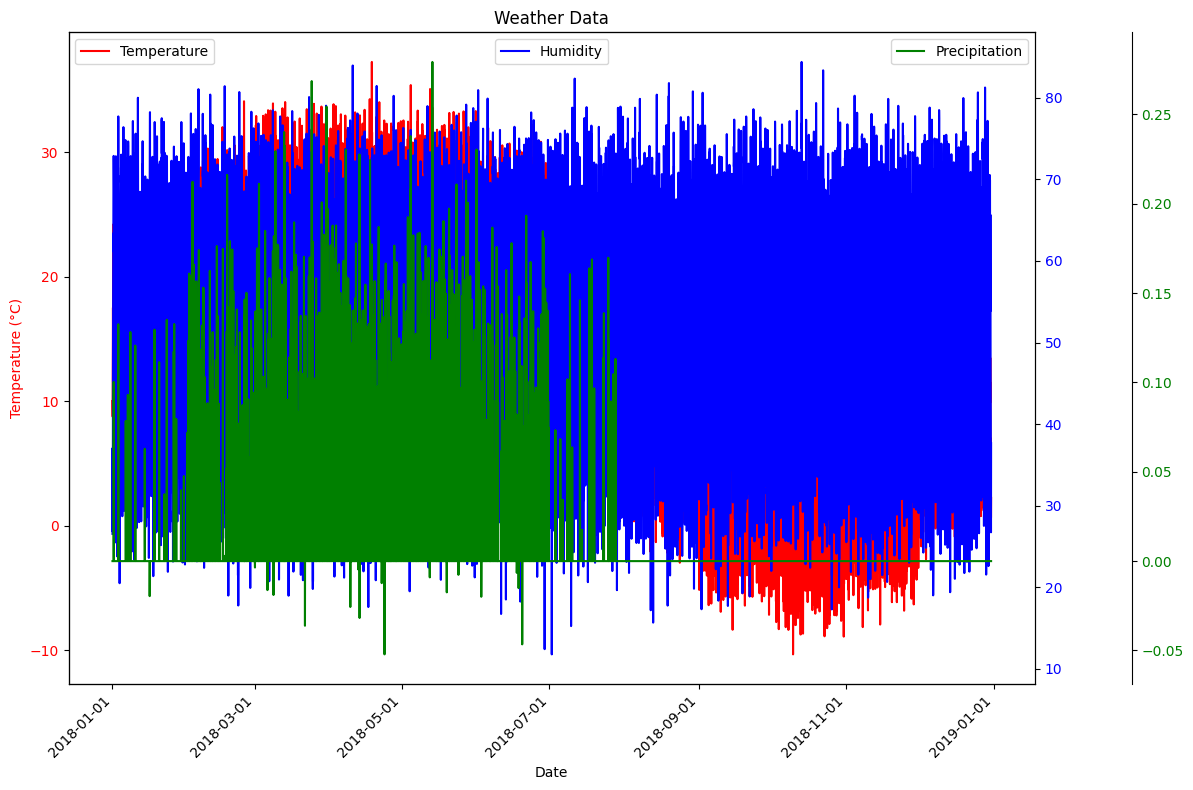

In [21]:
plot(weather_df, "Weather Data")

In [22]:
def daily_average(weather_data):
    # Resample the dataframe to daily frequence and calculate the mean for each day
    daily_data = weather_data.resample('D').mean()

    # Remove any NaN values that might have been introduced by the resampling operation
    daily_data = daily_data.dropna()

    return daily_data

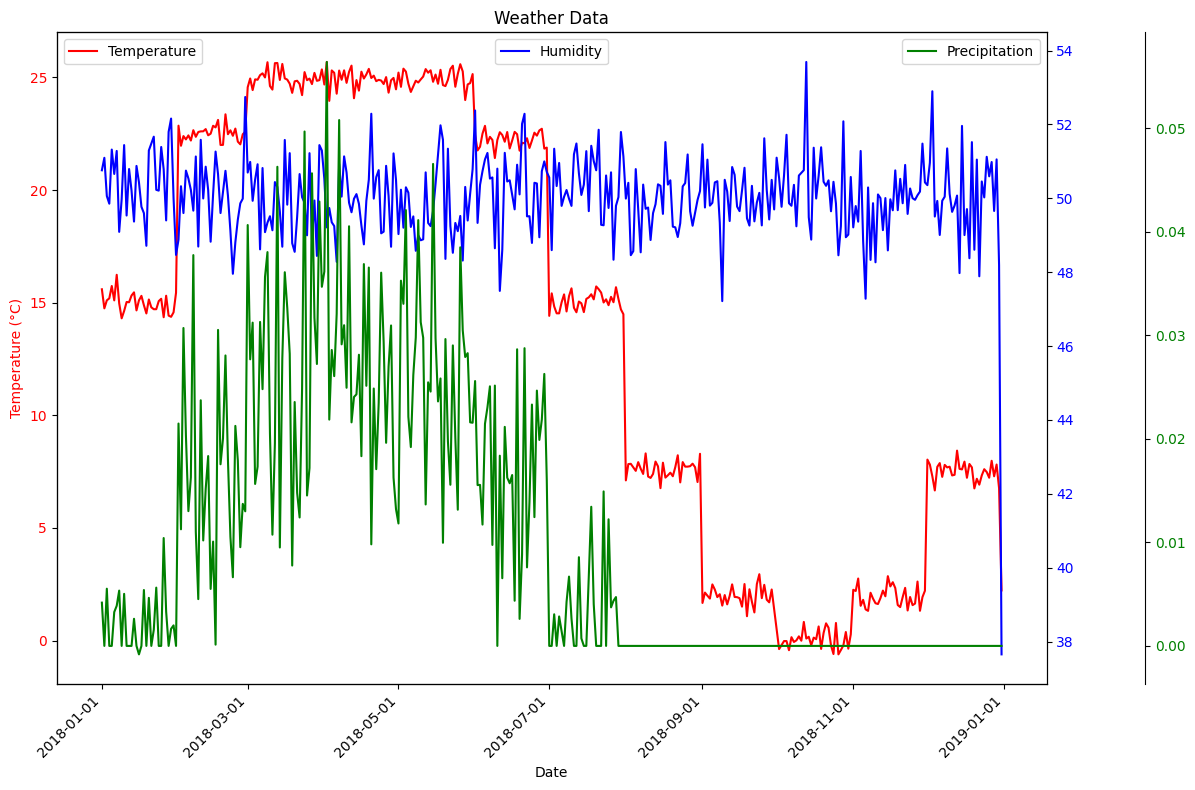

In [23]:
plot(daily_average(weather_df), "Weather Data")

In [26]:
short_weather = generate_weather('2018-01-01', '2018-01-06')

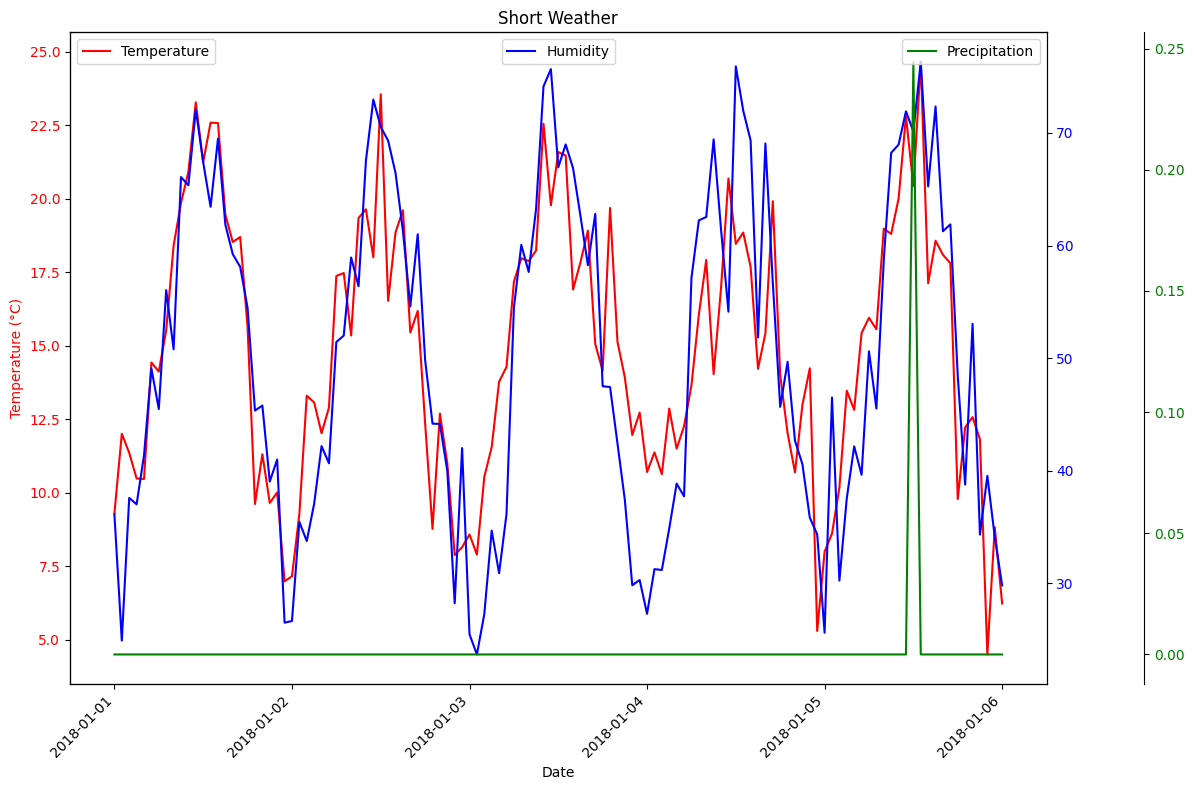

In [27]:
plot(short_weather, 'Short Weather')

# Improve our model with historical data for a location

In [33]:
cape_town_data = {
    'avg_temps': np.array([20, 20.1, 18.9, 16.9, 15.1, 13.6, 13, 13, 14, 15.7, 17.1, 19]),
    'avg_humidity': np.array([17, 16, 18, 50, 72, 112, 103, 90, 55, 36, 32, 20]),
    'avg_precipitation': np.array([73, 74, 75, 77, 80, 78, 77, 77, 74, 73, 72, 72])
}


lulea_data = {
    'avg_temps': np.array([-7.8, -7.9, -4.5, 0.6, 6.9, 12.2, 16.3, 15, 10.5, 3.9, -0.8, -4.6]),
    'avg_humidity': np.array([50, 37, 35, 34, 41, 57, 61, 68, 64, 60, 63, 58]),
    'avg_precipitation': np.array([86, 85, 81, 78, 69, 69, 73, 76, 78, 84, 86, 84])
}

In [35]:
def generate_weather_loc(start_date, end_date, location_data=None):
    # create a time index with hourly frequency
    idx = pd.date_range(start_date, end_date, freq='H')

    # extract the month and hour from the time index
    month = idx.month - 1
    hour = idx.hour

    # use the location data if provided, otherwise generate the temperature, humidity, and precipitation data with seasonal variations and diurnal cycle
    if location_data is not None:
        avg_temps = location_data['avg_temps']
        avg_humidity = location_data['avg_humidity']
        avg_precipitation = location_data['avg_precipitation']
        temp_seasonal = pd.Series(avg_temps[month], index=idx)
        hum_base = pd.Series(avg_humidity[month], index=idx)
        p_base = pd.Series(avg_precipitation[month] / 30 / 24, index=idx)
    else:
        temp_seasonal = pd.Series((np.sin((month) / 12 * 2 * np.pi) * 15 + 15), index=idx)
        temp_seasonal = temp_seasonal.clip(lower=-20, upper=35)
        hum_base = pd.Series(50, index=idx)
        p_base = pd.Series(0, index=idx)

    # generate temperature data with diurnal cycle and random noise
    temp_diurnal = np.cos((hour - 12) / 24 * 2 * np.pi) * 5
    temp_noise = np.random.normal(0, 2, len(idx))
    temp = temp_seasonal + temp_diurnal + temp_noise

    # generate humidity data with diurnal cycle and random noise
    hum_diurnal = np.sin((hour - 6) / 24 * 2 * np.pi) * 20
    hum_noise = np.random.normal(0, 5, len(idx))
    hum = hum_base + hum_diurnal + hum_noise

    # generate precipitation data with seasonal variations, random noise, and higher probability during summer
    p_seasonal = np.sin((month) / 12 * 2 * np.pi) * 0.1 + 0.2
    p_summer = (temp > 20) & (np.random.rand(len(idx)) < p_seasonal)
    p_noise = np.random.normal(0, 0.05, len(idx))
    p = p_base + p_summer.astype(float) * (0.1 + p_noise)

    # create a pandas dataframe with the generated values
    data = {'Temperature': temp,'Humidity': hum, 'Precipitation': p}
    df = pd.DataFrame(data, index=idx)

    return df

In [36]:
start_date = '2022-01-01'
end_date = '2022-12-31'
cape_town_weather = generate_weather_loc(start_date, end_date, cape_town_data)
lulea_weather = generate_weather_loc(start_date, end_date, lulea_data)

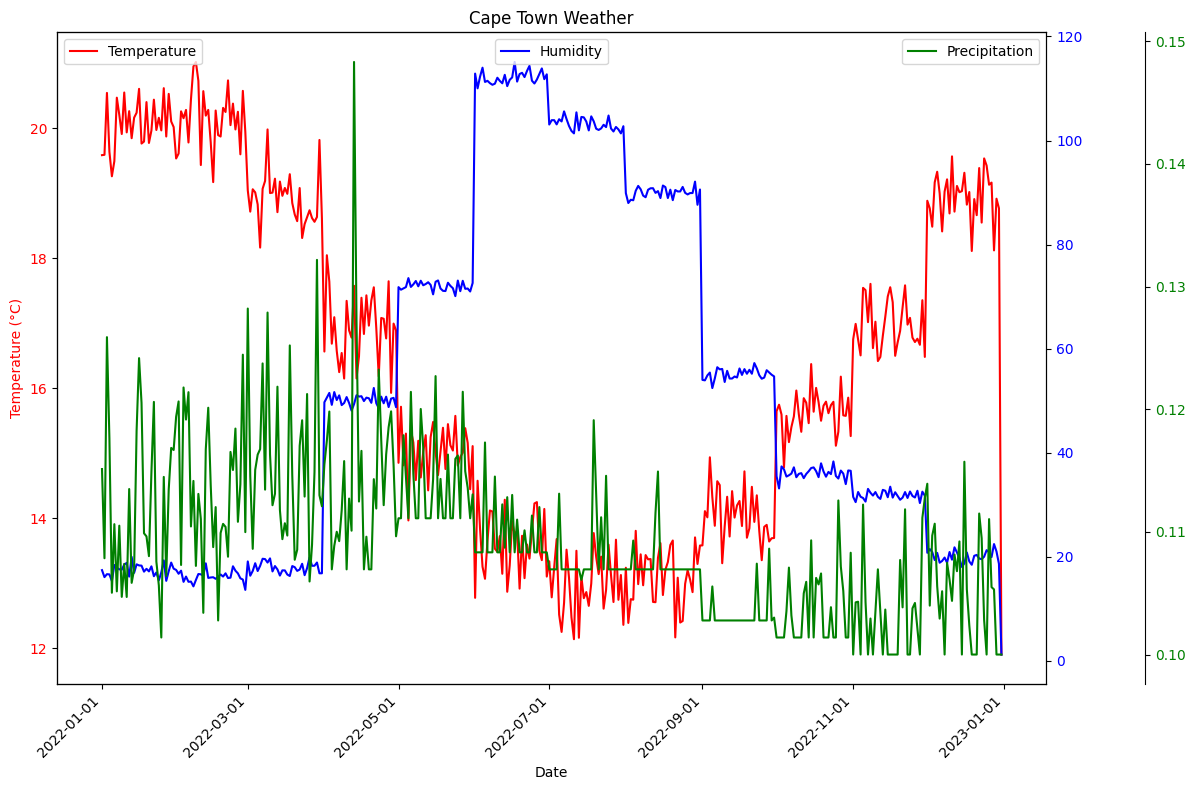

In [37]:
plot(daily_average(cape_town_weather), 'Cape Town Weather')

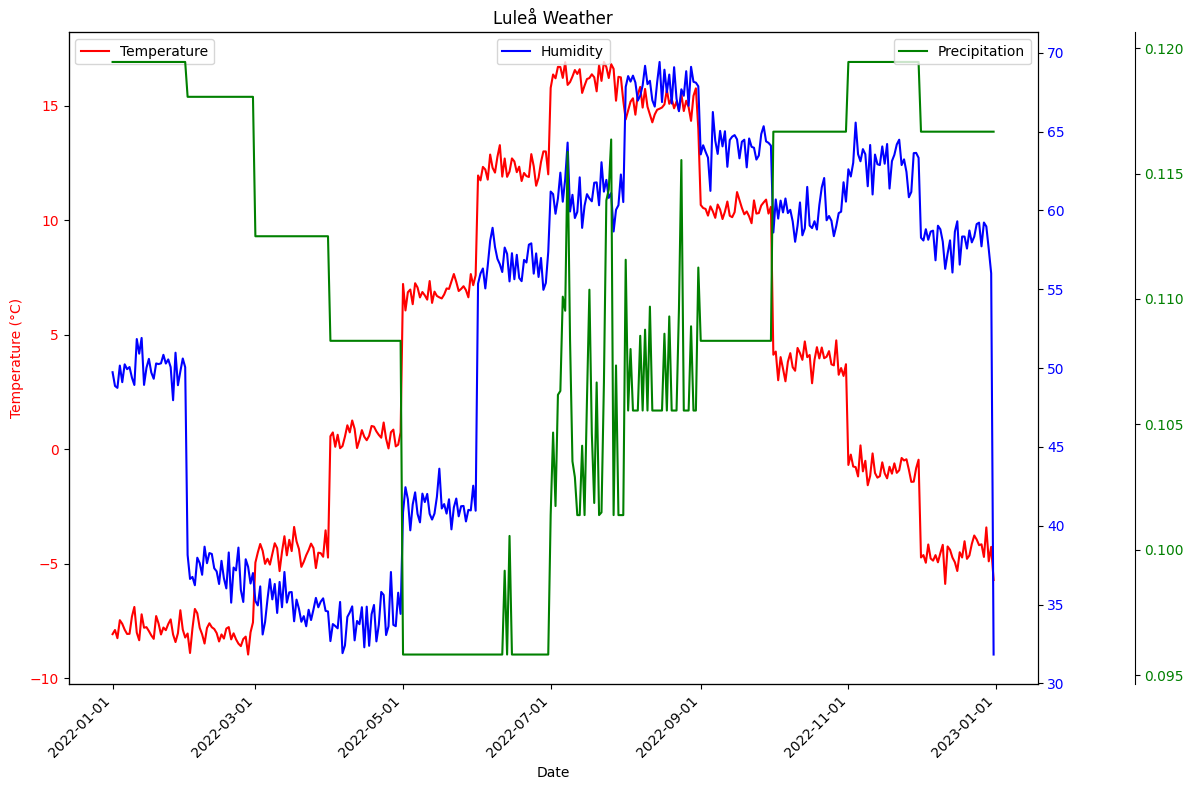

In [38]:
plot(daily_average(lulea_weather), 'Luleå Weather')

In [39]:
start_date = '2012-01-01'
end_date = '2022-12-31'
cape_town_weather = generate_weather_loc(start_date, end_date, cape_town_data)
lulea_weather = generate_weather_loc(start_date, end_date, lulea_data)

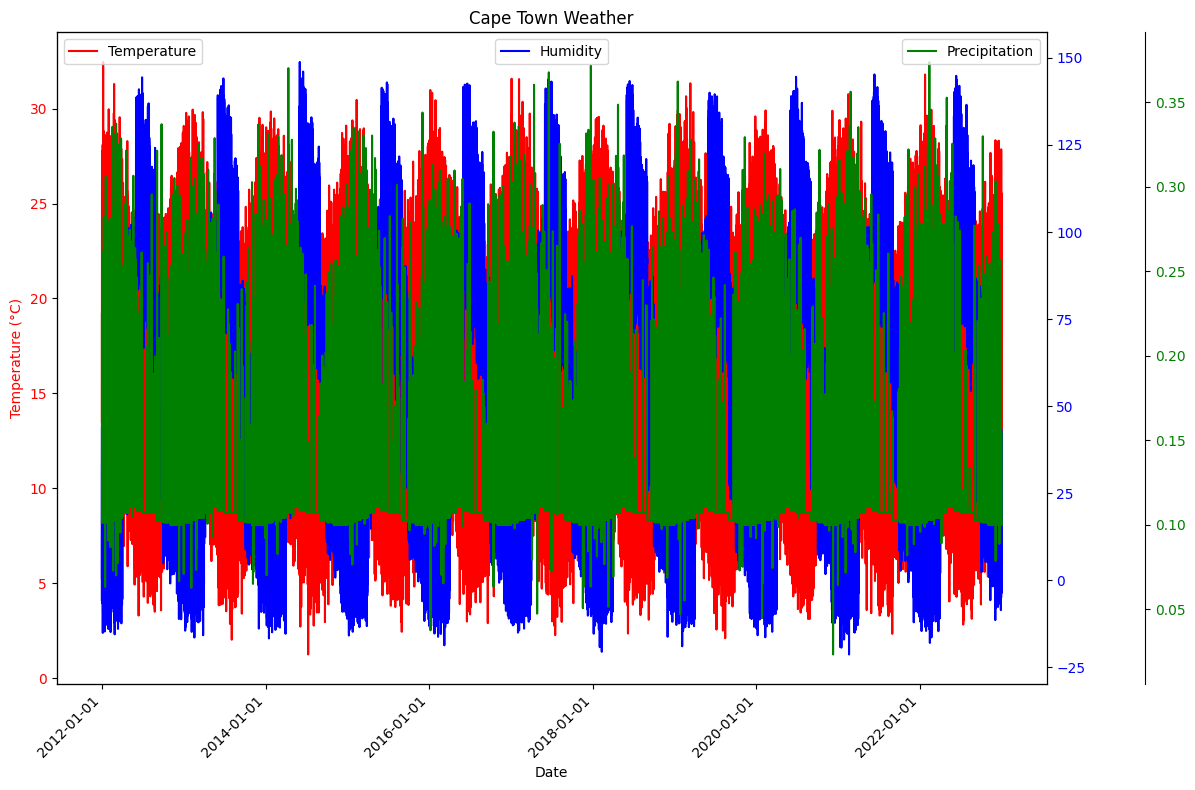

In [41]:
plot(cape_town_weather, 'Cape Town Weather')